In [1]:
import io
import urllib
import collections
import logging
import warnings

import numpy as np
import matplotlib.image
import matplotlib.pyplot as plt
import matplotlib.gridspec

%matplotlib inline

import pandas
import skimage
import skimage.util
import skimage.data
import skimage.color

import skimage.segmentation
import skimage.feature
import sklearn.cluster

warnings.filterwarnings('ignore')


## Choose a painting


In [2]:
# use a painting
url = 'https://upload.wikimedia.org/wikipedia/commons/7/7b/Vincent_van_Gogh_-_The_yellow_house_%28%27The_street%27%29.jpg'
# specify how many colors we want
n_colors = 15

## Download and convert to array

In [3]:
# read the data
f = io.BytesIO(urllib.urlopen(url).read())

In [4]:
# convert in memory to an image
img = matplotlib.image.imread(f, format='jpeg')

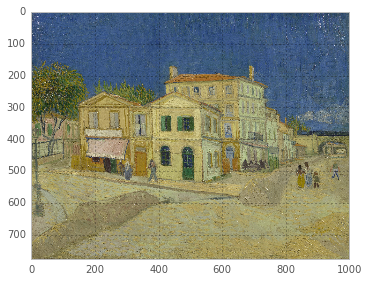

In [5]:
# downscale to at ...x1000
img = skimage.transform.rescale(img, 1000.0/max(img.shape))
plt.imshow(img)
plt.tight_layout()


## Split up to picture into small pieces

In [6]:
# about 20 segments in x and y
n_segments = 20*20 # separate image into n segments


In [7]:
labels = skimage.segmentation.slic(img, n_segments=n_segments, compactness=20, enforce_connectivity=True) # split up
shuffled = np.arange(n_segments) # create labels
np.random.shuffle(shuffled) # and shuffle them
colors = matplotlib.cm.Accent( matplotlib.colors.Normalize(vmax=n_segments)(shuffled)) # lookup a color

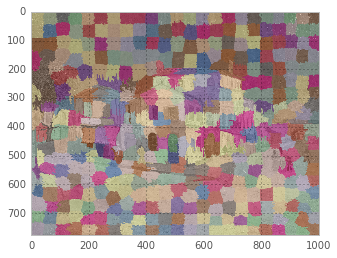

In [8]:
# this does not mix in the background
plt.imshow(colors[labels]) 
# this does
plt.imshow(skimage.color.label2rgb(labels, img, colors=colors, alpha=0.5))

## Compute average colors and centers

In [9]:
regionprops =  skimage.measure.regionprops(labels+1)
slices = [np.s_[props.bbox[0]:props.bbox[2], props.bbox[1]:props.bbox[3]] for props in regionprops]

In [10]:
rows = []
for i, (region, slice) in enumerate(zip(regionprops, slices)):
    row = dict(label= i, color = np.mean(img[slice][region.image], axis=0), x=region.centroid[0], y=region.centroid[1])
    rows.append(row)

In [11]:
df = pandas.DataFrame.from_records(rows)
mean_colors = np.array(list(df['color'].apply(list)))

## Plot the picture with average colors per area

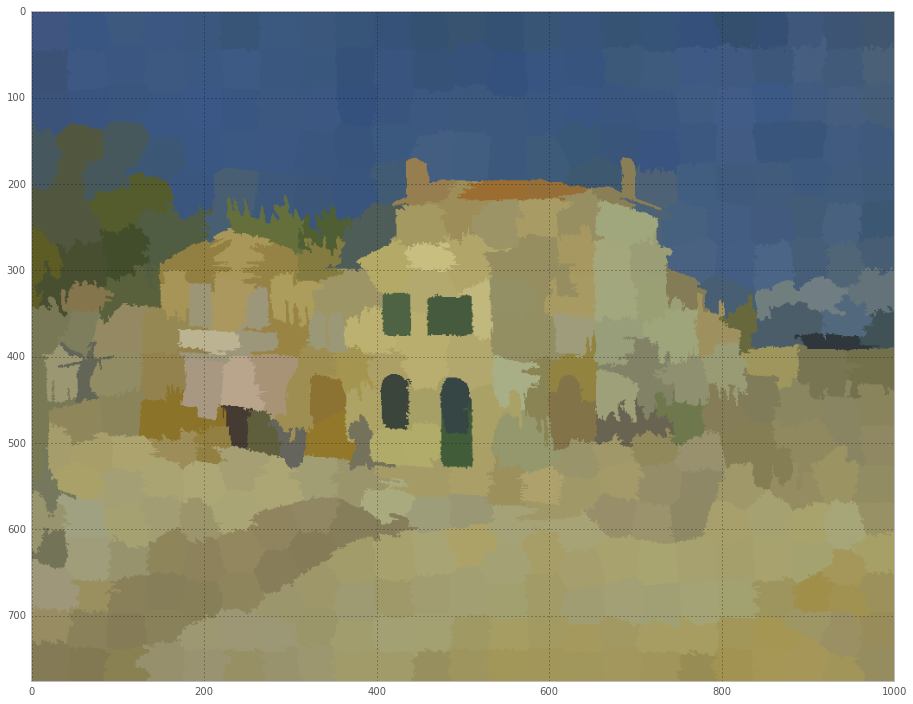

In [12]:
fig, ax= plt.subplots(figsize=(20,12))
ax.imshow(mean_colors[labels])
# or we could have just done
# ax.imshow(skimage.color.label2rgb(labels, img, kind='avg'))

## Reduce the number of colors

In [13]:
kmeans = sklearn.cluster.KMeans(n_clusters=n_colors)
kmeans.fit(mean_colors)
colorgroup = kmeans.predict(mean_colors)
colorgroups = kmeans.cluster_centers_

## Plot the picture with color numbers

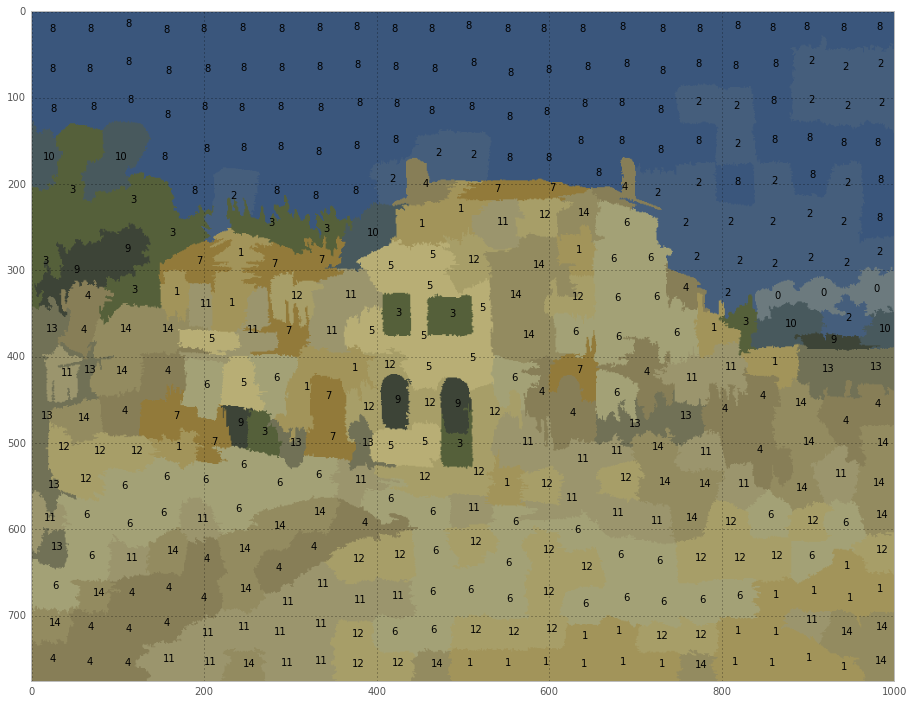

In [14]:
plt.subplots(figsize=(20,12))
plt.imshow(colorgroups[colorgroup[labels]])
for i, row in df.iterrows():
    plt.text(row['y'], row['x'], colorgroup[i])

## Show which colors we need

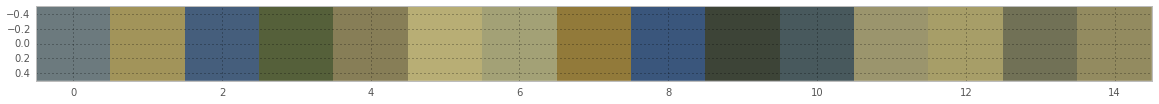

In [15]:
rgb = colorgroups[np.newaxis,:,:]
fig, ax = plt.subplots(figsize=(20,3))
ax.imshow(rgb, interpolation='none')


## Sort them by hue

In [16]:
hsv = matplotlib.colors.rgb_to_hsv(rgb)
sortidx = np.argsort(hsv.squeeze()[:,0], axis=0)


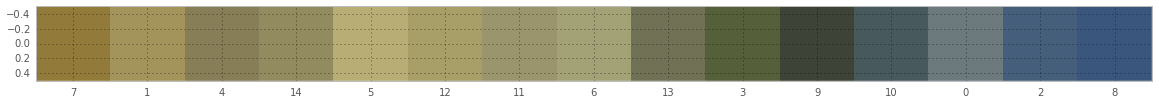

In [17]:
fig, ax = plt.subplots(figsize=(20,3))

ax.imshow(rgb[:,sortidx,:], interpolation='none')
_ = ax.set_xticks(np.arange(sortidx.shape[0]))
_ = ax.set_xticklabels(sortidx)

## How many do we need of each color

In [18]:
counter = collections.Counter(colorgroup)
pandas.DataFrame(data=dict(color=counter.keys(), n=counter.values())).sort('color')
    

,color,n
0,0,3
1,1,31
2,2,30
3,3,12
4,4,28
5,5,12
6,6,45
7,7,11
8,8,87
9,9,6


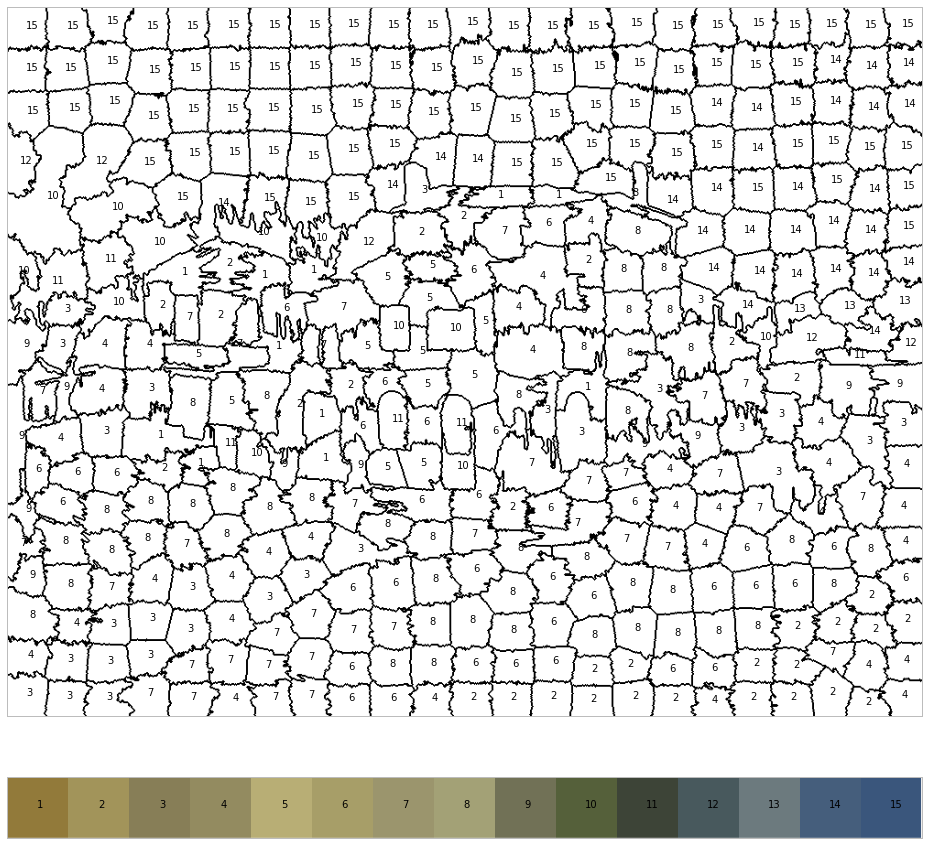

In [53]:
color_idx = np.argsort(sortidx)

fig, axes = plt.subplots(2, 1, figsize=(13,13), gridspec_kw=dict(height_ratios=[4,1]))

ax = axes[0]
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(skimage.segmentation.boundaries.find_boundaries(labels), cmap='Greys')
for i, row in df.iterrows():
    ax.text(row['y'], row['x'], color_idx[colorgroup[i]] + 1)

ax = axes[1]qs
ax.imshow(rgb[:,sortidx,:], interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
for i, idx in enumerate(color_idx[sortidx]):
    ax.text(i, 0, str(idx + 1))
fig.tight_layout()

In [43]:
def closest_color(rgb):
    """find the closest matching rgb label"""
    lab1 = skimage.color.rgb2lab(rgb[np.newaxis, np.newaxis, :])
    labels = [label 
              for label in dir(skimage.color.rgb_colors) 
              if not label.startswith('_')]
    rgbs = [getattr(skimage.color.rgb_colors, label) 
            for label 
            in labels]
    labs = [skimage.color.rgb2lab(np.array(rgb, dtype='float32')[np.newaxis, np.newaxis, :]) 
            for rgb
            in rgbs]
    distances = [skimage.color.deltaE_ciede94(lab1, lab2)
                 for lab2 in labs]
    idx = np.argmin(distances)
    return labels[idx]